# 🔍 Análisis de Clustering para EDA

Este notebook aplica técnicas de clustering (KMeans, DBSCAN) para descubrir patrones ocultos en los comentarios de YouTube.

## Objetivos:
1. Aplicar KMeans con diferentes valores de k
2. Aplicar DBSCAN para encontrar outliers
3. Visualizar clusters con PCA/t-SNE
4. Analizar características de cada cluster
5. Comparar clusters con etiquetas tóxicas/no tóxicas


## 1. Importar librerías


In [10]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Añadir src al path
sys.path.append(str(Path('../src').resolve()))

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Librerías importadas")


✅ Librerías importadas


## 2. Cargar datos vectorizados


In [11]:
from features.vectorization import load_vectorized_data

# Cargar datos vectorizados con TF-IDF
data_dir = Path('../data/processed')
X_train_tfidf, X_test_tfidf, y_train, y_test = load_vectorized_data(data_dir, prefix='tfidf')

# Combinar train y test para análisis completo
X_all = np.vstack([X_train_tfidf, X_test_tfidf])
y_all = pd.concat([y_train, y_test], ignore_index=True)

print(f"✅ Datos cargados:")
print(f"   Total ejemplos: {X_all.shape[0]}")
print(f"   Features: {X_all.shape[1]}")
print(f"   Tóxicos: {y_all.sum()}")
print(f"   No tóxicos: {len(y_all) - y_all.sum()}")


✅ Datos vectorizados cargados desde: ../data/processed
✅ Datos cargados:
   Total ejemplos: 1000
   Features: 1000
   Tóxicos: 462
   No tóxicos: 538


## 3. Reducir dimensionalidad para visualización


In [12]:
# Reducir a 2D con PCA para visualización
print("🔄 Reduciendo dimensionalidad con PCA...")
X_dense = X_all.toarray() if hasattr(X_all, 'toarray') else X_all
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense)

print(f"✅ PCA completado:")
print(f"   Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}")
print(f"   Componente 1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"   Componente 2: {pca.explained_variance_ratio_[1]:.2%}")


🔄 Reduciendo dimensionalidad con PCA...
✅ PCA completado:
   Varianza explicada: 3.01%
   Componente 1: 1.59%
   Componente 2: 1.42%


## 4. KMeans Clustering


In [13]:
# Probar diferentes valores de k
k_values = [2, 3, 4, 5]
kmeans_results = {}

print("🔄 Aplicando KMeans con diferentes k...")
print("="*60)

# Reducir dimensionalidad para KMeans (muy lento con 5000 features)
pca_kmeans = PCA(n_components=100, random_state=42)
X_reduced = pca_kmeans.fit_transform(X_dense)

for k in k_values:
    print(f"\n📊 KMeans con k={k}:")
    
    # Aplicar KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_reduced)
    
    # Calcular silhouette score
    silhouette = silhouette_score(X_reduced, labels)
    
    # Comparar con etiquetas reales (adjusted rand index)
    ari = adjusted_rand_score(y_all, labels)
    
    # Distribución de clusters
    unique, counts = np.unique(labels, return_counts=True)
    
    kmeans_results[k] = {
        'labels': labels,
        'silhouette': silhouette,
        'ari': ari,
        'distribution': dict(zip(unique, counts))
    }
    
    print(f"   Silhouette Score: {silhouette:.4f}")
    print(f"   Adjusted Rand Index: {ari:.4f}")
    print(f"   Distribución de clusters:")
    for cluster_id, count in sorted(kmeans_results[k]['distribution'].items()):
        print(f"      Cluster {cluster_id}: {count} ejemplos")


🔄 Aplicando KMeans con diferentes k...

📊 KMeans con k=2:
   Silhouette Score: 0.1516
   Adjusted Rand Index: 0.0082
   Distribución de clusters:
      Cluster 0: 26 ejemplos
      Cluster 1: 974 ejemplos

📊 KMeans con k=3:
   Silhouette Score: 0.0498
   Adjusted Rand Index: 0.0140
   Distribución de clusters:
      Cluster 0: 142 ejemplos
      Cluster 1: 839 ejemplos
      Cluster 2: 19 ejemplos

📊 KMeans con k=4:
   Silhouette Score: 0.0499
   Adjusted Rand Index: 0.0399
   Distribución de clusters:
      Cluster 0: 786 ejemplos
      Cluster 1: 49 ejemplos
      Cluster 2: 19 ejemplos
      Cluster 3: 146 ejemplos

📊 KMeans con k=5:
   Silhouette Score: 0.0406
   Adjusted Rand Index: 0.0037
   Distribución de clusters:
      Cluster 0: 134 ejemplos
      Cluster 1: 595 ejemplos
      Cluster 2: 19 ejemplos
      Cluster 3: 188 ejemplos
      Cluster 4: 64 ejemplos


## 5. Visualizar KMeans


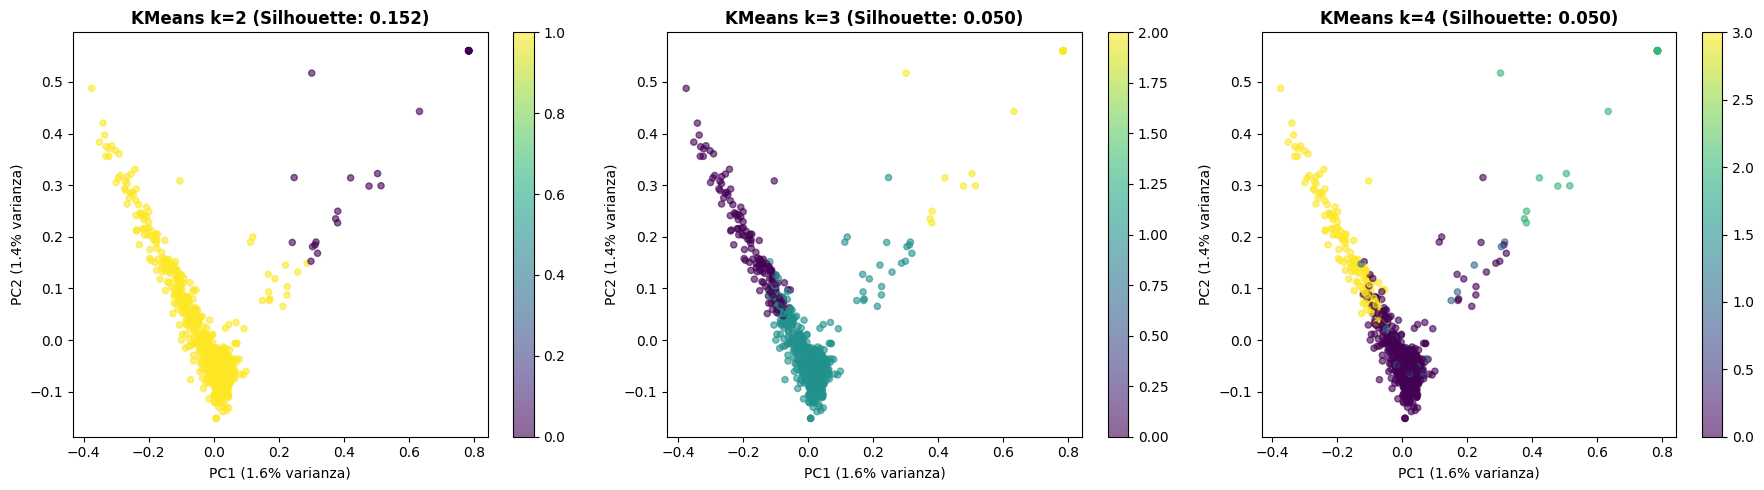

✅ Gráficos guardados en: ../data/processed/kmeans_clusters.png


In [14]:
# Visualizar clusters con PCA 2D
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, k in enumerate([2, 3, 4]):
    ax = axes[idx]
    labels = kmeans_results[k]['labels']
    
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6, s=20)
    ax.set_title(f'KMeans k={k} (Silhouette: {kmeans_results[k]["silhouette"]:.3f})', fontsize=12, fontweight='bold')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.savefig('../data/processed/kmeans_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Gráficos guardados en: ../data/processed/kmeans_clusters.png")


## 6. Análisis de Clusters vs Etiquetas Reales


In [15]:
# Analizar relación entre clusters y etiquetas tóxicas
print("📊 Análisis de Clusters vs Etiquetas Reales (KMeans k=2):")
print("="*60)

k = 2
labels = kmeans_results[k]['labels']

# Crear DataFrame para análisis
cluster_df = pd.DataFrame({
    'cluster': labels,
    'is_toxic': y_all.values
})

# Contar por cluster y etiqueta
crosstab = pd.crosstab(cluster_df['cluster'], cluster_df['is_toxic'], margins=True)
print("\nTabla de contingencia:")
print(crosstab)

# Porcentaje de tóxicos por cluster
print("\n📈 Porcentaje de tóxicos por cluster:")
for cluster_id in sorted(cluster_df['cluster'].unique()):
    cluster_data = cluster_df[cluster_df['cluster'] == cluster_id]
    toxic_pct = (cluster_data['is_toxic'].sum() / len(cluster_data)) * 100
    print(f"   Cluster {cluster_id}: {toxic_pct:.1f}% tóxicos ({cluster_data['is_toxic'].sum()}/{len(cluster_data)})")


📊 Análisis de Clusters vs Etiquetas Reales (KMeans k=2):

Tabla de contingencia:
is_toxic    0    1   All
cluster                 
0           3   23    26
1         535  439   974
All       538  462  1000

📈 Porcentaje de tóxicos por cluster:
   Cluster 0: 88.5% tóxicos (23/26)
   Cluster 1: 45.1% tóxicos (439/974)


## 7. DBSCAN Clustering


In [16]:
print("🔄 Aplicando DBSCAN...")
print("="*60)

# Reducir dimensionalidad para DBSCAN
pca_dbscan = PCA(n_components=50, random_state=42)
X_reduced_dbscan = pca_dbscan.fit_transform(X_dense)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_reduced_dbscan)

# Análisis de resultados
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\n📊 Resultados DBSCAN:")
print(f"   Número de clusters: {n_clusters}")
print(f"   Puntos de ruido (outliers): {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")

# Distribución de clusters
unique, counts = np.unique(dbscan_labels, return_counts=True)
print(f"\n   Distribución:")
for cluster_id, count in zip(unique, counts):
    if cluster_id == -1:
        print(f"      Ruido (outliers): {count} ejemplos")
    else:
        print(f"      Cluster {cluster_id}: {count} ejemplos")


🔄 Aplicando DBSCAN...

📊 Resultados DBSCAN:
   Número de clusters: 1
   Puntos de ruido (outliers): 81 (8.1%)

   Distribución:
      Ruido (outliers): 81 ejemplos
      Cluster 0: 919 ejemplos


## 8. Visualizar DBSCAN y Comparar con Etiquetas Reales


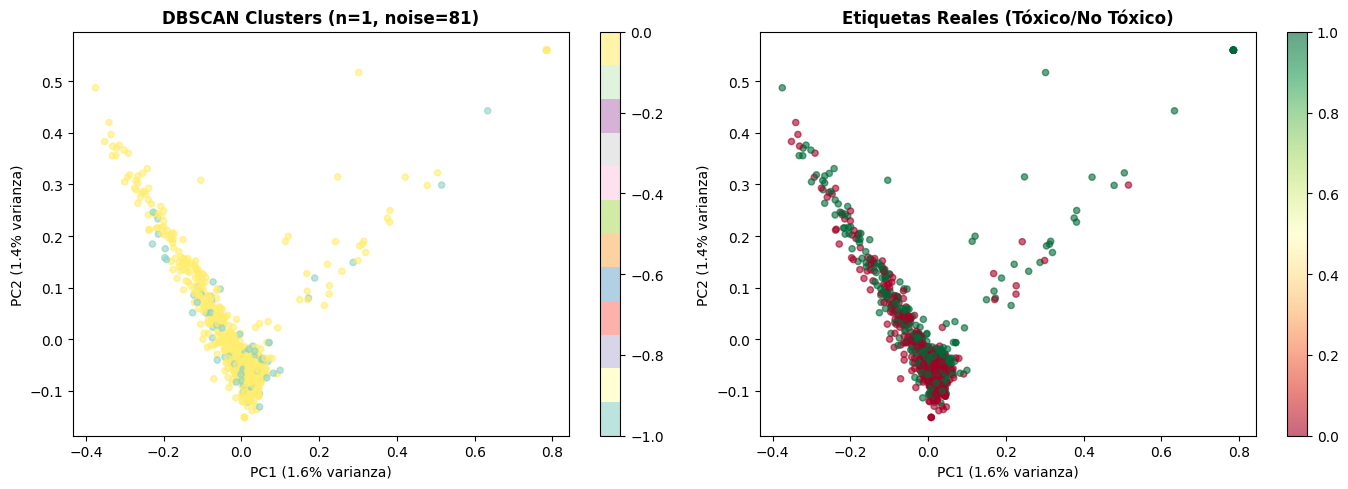

✅ Gráficos guardados en: ../data/processed/dbscan_clusters.png


In [17]:
# Visualizar DBSCAN con PCA 2D
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DBSCAN clusters
ax1 = axes[0]
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='Set3', alpha=0.6, s=20)
ax1.set_title(f'DBSCAN Clusters (n={n_clusters}, noise={n_noise})', fontsize=12, fontweight='bold')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.colorbar(scatter1, ax=ax1)

# Etiquetas reales para comparar
ax2 = axes[1]
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y_all.values, cmap='RdYlGn', alpha=0.6, s=20)
ax2.set_title('Etiquetas Reales (Tóxico/No Tóxico)', fontsize=12, fontweight='bold')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.savefig('../data/processed/dbscan_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Gráficos guardados en: ../data/processed/dbscan_clusters.png")


## 9. Comparación de Métodos de Clustering


In [ ]:
# Crear tabla comparativa
comparison_data = []

for k in k_values:
    comparison_data.append({
        'Método': f'KMeans k={k}',
        'N Clusters': k,
        'Silhouette Score': kmeans_results[k]['silhouette'],
        'ARI vs Labels': kmeans_results[k]['ari']
    })

# Añadir DBSCAN
if n_clusters > 0:
    non_noise_mask = dbscan_labels != -1
    # Calcular silhouette solo si hay al menos 2 clusters válidos
    if non_noise_mask.sum() > 1 and n_clusters >= 2:
        try:
            dbscan_silhouette = silhouette_score(X_reduced_dbscan[non_noise_mask], dbscan_labels[non_noise_mask])
        except ValueError:
            # Si solo hay 1 cluster válido, no se puede calcular silhouette
            dbscan_silhouette = np.nan
    else:
        dbscan_silhouette = np.nan
    
    comparison_data.append({
        'Método': 'DBSCAN',
        'N Clusters': n_clusters,
        'Silhouette Score': dbscan_silhouette,
        'ARI vs Labels': adjusted_rand_score(y_all, dbscan_labels)
    })

comparison_df = pd.DataFrame(comparison_data)
print("📊 Comparación de Métodos de Clustering:")
print("="*60)
print(comparison_df.to_string(index=False))

# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Silhouette scores
ax1 = axes[0]
methods = comparison_df['Método'].values
scores = comparison_df['Silhouette Score'].values
ax1.bar(range(len(methods)), scores, color='steelblue')
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score por Método', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# ARI scores
ax2 = axes[1]
ari_scores = comparison_df['ARI vs Labels'].values
ax2.bar(range(len(methods)), ari_scores, color='coral')
ax2.set_xticks(range(len(methods)))
ax2.set_xticklabels(methods, rotation=45, ha='right')
ax2.set_ylabel('Adjusted Rand Index')
ax2.set_title('ARI vs Etiquetas Reales', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/clustering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Análisis de clustering completado")


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)